# Определение возраста покупателей

Cетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# Библитеки для исследовательского анализа 
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

SEED = 1234

In [2]:
#Загрузим целевой признак из текущий папки 

pth_local_train = '/datasets/faces/labels.csv'

if os.path.exists(pth_local_train):
    labels = pd.read_csv(pth_local_train)
else:
    print('Something is wrong')

In [3]:
#Посмотрим на целевой признак

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


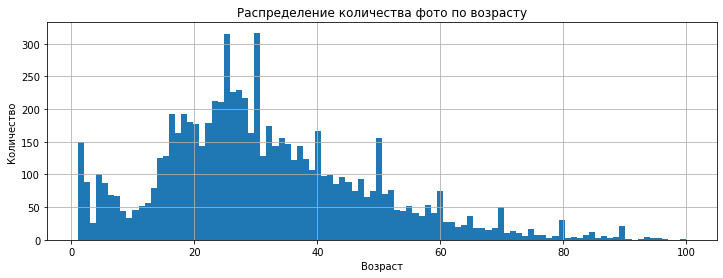

In [6]:
# Построим распределение фото по возрасту
fig = plt.figure(figsize=(12, 4))
labels['real_age'].hist(bins=max(labels['real_age']));
plt.title('Распределение количества фото по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество');

In [7]:
# Создадим загрузчик с батчем равным 16 изображения
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


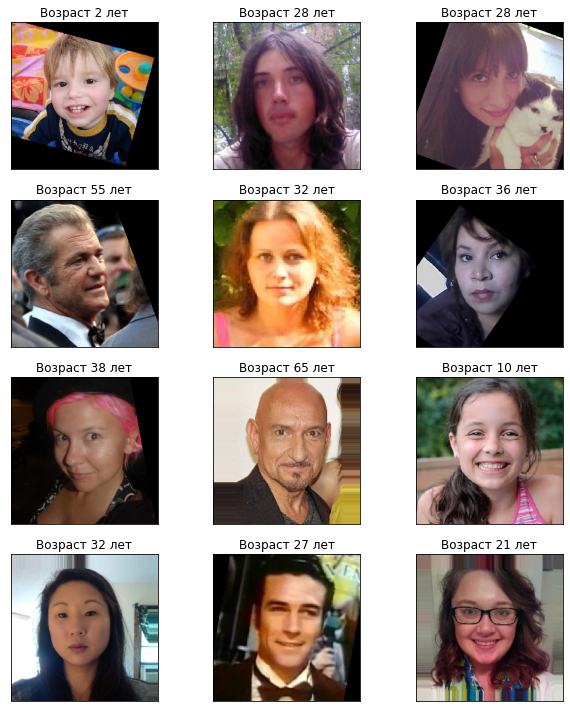

In [8]:
# Выведем первые 12 изображений
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.title('Возраст ' + target[i].astype('str') + ' лет')

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
Обучающая выборка представлена 7591 фотографией.

Возраст людей на фото от 1 до 100 лет. Средний возраст составляет 31 год.
Нормальное распределение возраста наблюдается только в диапазоне от 10 до 100 лет. 
Возраст менее 10 лет выбивается из нормального распределения. Фото с возрастом более 80 лет очень мало.

В целом возраст с 1 до 60 лет представлен не менее 40-50 фото на каждый год и можно ожидать хорошего обучения на этом диапазоне возраста.



## Обучение модели

Выделим из выборки валидационный сет в размере 25%. Обучим на нейросети на основе архитектуры ResNet50.

Т.к. у нас регрессионная задача, то в последнем слое будет только 1 нейрон с методом активации ReLu. Оптимизацию поиска минимума loss произведем методом Adam. Loss функция будет mse, метрика mae.

Код ниже был запущен на отдельном облачном сервисе от Яндекса. Результат его работы приведен ниже отдельным блоком формата Markdown

```

import numpy as np
import pandas as pd
import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

SEED = 1234

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    train_data_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(300, 300),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED)

    return train_data_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_data_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(300, 300),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=SEED)

    return test_data_flow

def create_model():

    backbone = ResNet50(input_shape=(300, 300, 3),
                    weights='imagenet',
                    include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error']) 

    return model

def train_model(model, train_data, test_data, epochs=6, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результат обучения модели:

```

Train for 178 steps, validate for 60 steps
Epoch 1/6
Epoch 2/6
178/178 - 77s - loss: 223.7365 - mean_absolute_error: 10.6237 - val_loss: 704.6215 - val_mean_absolute_error: 21.5297
178/178 - 46s - loss: 71.8568 - mean_absolute_error: 6.4600 - val_loss: 634.0538 - val_mean_absolute_error: 20.0907
Epoch 3/6
178/178 - 64s - loss: 39.9200 - mean_absolute_error: 4.8807 - val_loss: 221.6416 - val_mean_absolute_error: 11.3226
Epoch 4/6
178/178 - 64s - loss: 25.7674 - mean_absolute_error: 3.9111 - val_loss: 152.1711 - val_mean_absolute_error: 9.9595
Epoch 5/6
178/178 - 49s - loss: 18.6055 - mean_absolute_error: 3.3318 - val_loss: 82.3036 - val_mean_absolute_error: 6.7733
Epoch 6/6
178/178 - 58s - loss: 12.4304 - mean_absolute_error: 2.7121 - val_loss: 69.6997 - val_mean_absolute_error: 6.1565

60/60 - 11s - loss: 69.6997 - mean_absolute_error: 6.1565
Test MAE: 6.1565
```

Обучение модели на 6 эпохах менее чем за 10 минут приводит к лучшему результату метрики mae на валидационной выборке в размере 6.16

## Анализ обученной модели

**Вывод:**

На датасете в 7591 фото с разбивкой train/valid  = 75%/25% обучена нейросеть с архитектурой ResNet50.

В качестве Loss function использовали MSE, оптимизация параметров методом ADAM. В ходе 5 эпох с learning_rate=0.0002 менее чем за 10 минут на GPU достигнута точность предсказания в 6.16 года по метрике MAE на тестовой выборке. Наблюдается некоторое переобучение, т.к. на обучающей выборке точность в 2 раза меньше, но в целом точность на тесте удовлетворительная.